In [1]:

# CodeP3.4F25 - V.P. Carey, ME249 F25

#import useful packages
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import tensorflow as tf
#the following 2 lines are only needed for Mac OS machines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#create input data array

#convert to:
# BC's for PINN conduction model with HE enforcement in interior points

# x(cm), y(cm)   These are (x,y) coordinates of boundary location where temperature is specified from measurements
xdata = []
ND = 32
xdata =  [  [ 0.0, 0.0 ], [ 0.0, 0.5 ], [ 0.0, 1.0 ], [ 0.0, 1.5 ],[ 0.0, 2.0 ], [ 0.0, 2.5 ], [ 0.0, 3.0 ],
            [ 0.0, 3.5 ], [ 0.0, 4.0 ], [ 0.0, 4.5 ], [ 0.0, 5.0 ],
            [ 3.0, 0.0 ], [ 3.0, 0.5 ], [ 3.0, 1.0 ], [ 3.0, 1.5 ],[ 3.0, 2.0 ], [ 3.0, 2.5 ], [ 3.0, 3.0 ],
            [ 3.0, 3.5 ], [ 3.0, 4.0 ], [ 3.0, 4.5 ], [ 3.0, 5.0 ]]
   
xdata.append([  0.5, 0.0 ])
xdata.append([  1.0, 0.0 ])
xdata.append([  1.5, 0.0 ])
xdata.append([  2.0, 0.0 ])
xdata.append([  2.5, 0.0 ])

xdata.append([  0.5, 5.0 ])
xdata.append([  1.0, 5.0 ])
xdata.append([  1.5, 5.0 ])
xdata.append([  2.0, 5.0 ])
xdata.append([  2.5, 5.0 ])
  
    
# add more here if needed
   


xarray= np.array(xdata)
print (xdata)
print (xarray)


    
#convert to:
# meadian values of output variables

# T (deg C)   These are specified (measured) temperatures for each pair of (x,y) above

ydata = []

ydata = [ [ 50. ], [ 50. ], [ 50. ], [ 50. ], [ 50. ], [ 45. ], [ 40. ], [ 35. ], [ 30. ], [ 25. ], [ 20. ], 
         [ 40. ], [ 35. ],  [ 30. ], [ 25. ], [ 20. ], [ 15. ], [ 10. ], [ 10. ], [ 10. ], [ 10. ], [ 10. ] ]
    
ydata.append([ 50. ])
ydata.append([ 50. ])
ydata.append([ 50. ])
ydata.append([ 50. ])
ydata.append([ 45. ])

ydata.append([ 15. ])
ydata.append([ 10. ])
ydata.append([ 10. ])
ydata.append([ 10. ])
ydata.append([ 10. ])

# add more here if needed

yarray= np.array(ydata)
print (ydata)
print (yarray)

data_inputs = np.array(xdata)
data_outputs = np.array(ydata)

#boundary_x = ...  # x-coordinates for the boundary data
#boundary_y = ...  # y-coordinates for the boundary data
#boundary_T = ...  # Boundary temperature data (T_data)
    
# Copy the first column to a 1D numpy array
#vector = arr[:, 0].copy()
boundary_xnp = xarray[:, 0].copy()
# Copy the first column to a 1D numpy array
boundary_ynp = xarray[:, 1].copy()
boundary_Tnp = yarray[:, 0].copy()
    
# Convert the arrays to a TensorFlow tensors
boundary_x = tf.convert_to_tensor(boundary_xnp, dtype=tf.float32)
boundary_y = tf.convert_to_tensor(boundary_ynp, dtype=tf.float32)
boundary_T_ytrain = tf.convert_to_tensor(boundary_Tnp, dtype=tf.float32)

boundary_points_xtrain = tf.stack([boundary_x, boundary_y], axis=1)

print(boundary_points_xtrain)
print(boundary_T_ytrain)
    

[[0.0, 0.0], [0.0, 0.5], [0.0, 1.0], [0.0, 1.5], [0.0, 2.0], [0.0, 2.5], [0.0, 3.0], [0.0, 3.5], [0.0, 4.0], [0.0, 4.5], [0.0, 5.0], [3.0, 0.0], [3.0, 0.5], [3.0, 1.0], [3.0, 1.5], [3.0, 2.0], [3.0, 2.5], [3.0, 3.0], [3.0, 3.5], [3.0, 4.0], [3.0, 4.5], [3.0, 5.0], [0.5, 0.0], [1.0, 0.0], [1.5, 0.0], [2.0, 0.0], [2.5, 0.0], [0.5, 5.0], [1.0, 5.0], [1.5, 5.0], [2.0, 5.0], [2.5, 5.0]]
[[0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.  1.5]
 [0.  2. ]
 [0.  2.5]
 [0.  3. ]
 [0.  3.5]
 [0.  4. ]
 [0.  4.5]
 [0.  5. ]
 [3.  0. ]
 [3.  0.5]
 [3.  1. ]
 [3.  1.5]
 [3.  2. ]
 [3.  2.5]
 [3.  3. ]
 [3.  3.5]
 [3.  4. ]
 [3.  4.5]
 [3.  5. ]
 [0.5 0. ]
 [1.  0. ]
 [1.5 0. ]
 [2.  0. ]
 [2.5 0. ]
 [0.5 5. ]
 [1.  5. ]
 [1.5 5. ]
 [2.  5. ]
 [2.5 5. ]]
[[50.0], [50.0], [50.0], [50.0], [50.0], [45.0], [40.0], [35.0], [30.0], [25.0], [20.0], [40.0], [35.0], [30.0], [25.0], [20.0], [15.0], [10.0], [10.0], [10.0], [10.0], [10.0], [50.0], [50.0], [50.0], [50.0], [45.0], [15.0], [10.0], [10.0], [10.0], [10.0]]
[[50.

In [2]:
# define neural network model
    
    #As seen below, we have created four dense layers. 
    #A dense layer is a layer in neural network that’s fully connected. 
    #In other words, all the neurons in one layer are connected to all other neurons in the next layer.
    #In the first layer, we need to provide the input shape, which is 1 in our case. 
    #The activation function we have chosen is elu, which stands for exponential linear unit. 
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
    
# Create your model (for example, a simple fully connected feedforward NN)
# Assume 2D input (x, y),  Output temperature T
model = Sequential([
        Dense(5, input_dim=2, activation='elu'),  
        Dense(10, activation='elu'),
        Dense(1)  
    ])  
    
# Set the kappa value (this can be adjusted as per your needs)
kappa = 1.3
    
# Set the x_max and y_max values of your domain ( can adjust these according to your problem)
x_max = 3.0
y_max = 5.0

#print summary of model features
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 15        
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [3]:
# PINN CUSTOM LOSS FUNCTION - V.P. Carey, ME249 F25

import tensorflow as tf
from tensorflow.keras import backend as K

def custom_loss_function(kappa, x_max, y_max, epoch_tracker):
    """ Custom loss function for the neural network model.
        - kappa: weight for the Laplace residual term.
        - x_max, y_max: maximum x and y coordinates of the domain.
        - epoch_tracker: callback object to keep track of the current epoch. """
    
    def loss(y_true, y_pred):    
        # Define pointsBoundaryChk as a constant tensor
        pointsBoundaryChk = tf.constant([
            [ 0.0, 0.0 ],
            [ 0.0, 0.5 ],
            [ 0.0, 1.0 ],
            [ 0.0, 1.5 ],
            [ 0.0, 2.0 ],
            [ 0.0, 2.5 ],
            [ 0.0, 3.0 ],
            [ 0.0, 3.5 ],
            [ 0.0, 4.0 ],
            [ 0.0, 4.5 ],
            [ 0.0, 5.0 ],
            [ 0.5, 5.0 ],
            [ 1.0, 5.0 ],
            [ 1.5, 5.0 ],
            [ 2.0, 5.0 ],
            [ 2.5, 5.0 ],
            [ 3.0, 5.0 ],
            [ 3.0, 4.5 ],
            [ 3.0, 4.0 ],
            [ 3.0, 3.5 ],
            [ 3.0, 3.0 ],
            [ 3.0, 2.5 ],
            [ 3.0, 2.0 ],
            [ 3.0, 1.5 ],
            [ 3.0, 1.0 ],
            [ 3.0, 0.5 ],
            [ 3.0, 0.0 ],
            [ 2.5, 0.0 ],
            [ 2.0, 0.0 ],
            [ 1.5, 0.0 ],
            [ 1.0, 0.0 ],
            [ 0.5, 0.0 ],
        ], dtype=tf.float32)
        
        # Boundary loss: Calculate squared error for the boundary condition
        boundary_loss = K.mean(K.square(y_pred - y_true))
        
        ESbdsum = 0.
        for _ in range(32):
            # Sample a random index and gather point
            idx = tf.random.uniform(shape=[], minval=0, maxval=32, dtype=tf.int32)
            selected_point = tf.gather(pointsBoundaryChk, idx)
                
            # Stack selected_point as input for the model (shape becomes (1, 2))
            input_tensor = tf.expand_dims(selected_point, axis=0)
            # Pass input_tensor as the input to the model
            T_pred_at_boundxy = model(input_tensor)  # Model prediction
            # add penalty if temperature at flux location is OUTSIDE RANGE 5-55 DEG C
            if (T_pred_at_boundxy < 5.):
                ESbdsum += 20.*(5. - T_pred_at_boundxy)*(5. - T_pred_at_boundxy)
            if (T_pred_at_boundxy > 55.):
                ESbdsum += 20.*(T_pred_at_boundxy - 55.)*(T_pred_at_boundxy - 55.)
        boundary_loss += ESbdsum/32.
    
        # Check epoch from the callback
        epoch = epoch_tracker.epochs_trained
            
        # If current epoch is less than N_epInit, ignore the Laplace residual
        if epoch < epoch_tracker.N_epInit:
            total_loss = boundary_loss
        else:
            # 3. Randomly select an interior point from this list using TensorFlow's random uniform
            points = tf.constant([
                [ 0.5, 0.5 ],
                [ 1.0, 0.5 ],
                [ 1.5, 0.5 ],
                [ 2.0, 0.5 ],
                [ 2.5, 0.5 ],
                [ 0.5, 1.0 ],
                [ 1.0, 1.0 ],
                [ 1.5, 1.0 ],
                [ 2.0, 1.0 ],
                [ 2.5, 1.0 ],
                [ 0.5, 1.5 ],
                [ 1.0, 1.5 ],
                [ 1.5, 1.5 ],
                [ 2.0, 1.5 ],
                [ 2.5, 1.5 ],
                [ 0.5, 2.0 ],
                [ 1.0, 2.0 ],
                [ 1.5, 2.0 ],
                [ 2.0, 2.0 ],
                [ 2.5, 2.0 ],
                [ 0.5, 2.5 ],
                [ 1.0, 2.5 ],
                [ 1.5, 2.5 ],
                [ 2.0, 2.5 ],
                [ 2.5, 2.5 ],
                [ 0.5, 3.0 ],
                [ 1.0, 3.0 ],
                [ 1.5, 3.0 ],
                [ 2.0, 3.0 ],
                [ 2.5, 3.0 ],
                [ 0.5, 3.5 ],
                [ 1.0, 3.5 ],
                [ 1.5, 3.5 ],
                [ 2.0, 3.5 ],
                [ 2.5, 3.5 ],
                [ 0.5, 4.0 ],
                [ 1.0, 4.0 ],
                [ 1.5, 4.0 ],
                [ 2.0, 4.0 ],
                [ 2.5, 4.0 ],
                [ 0.5, 4.5 ],
                [ 1.0, 4.5 ],
                [ 1.5, 4.5 ],
                [ 2.0, 4.5 ],
                [ 2.5, 4.5 ],
            ], dtype=tf.float32)
            
            meanLap_res = 0.
            meanTlimPen = 0.
            for _ in range(45):
                ##compute Laplacian residue here - need to do this once per BC point - include in range 32 loop =======
                # Use tf.random.uniform to sample an index for the interior point
                idx = tf.random.uniform(shape=[], minval=0, maxval=45, dtype=tf.int32)
                selected_point = tf.gather(points, idx)
                x_interior, y_interior = selected_point[0], selected_point[1],
                
                # Use tf.GradientTape to compute second derivatives
                with tf.GradientTape(persistent=True) as tape:
                    tape.watch(selected_point)
                    # Pass the selected (x_interior, y_interior) to the model to get T_pred_at_interior
                    T_pred_at_interior = model([x_interior, y_interior])  # Model prediction
                
                # Compute first derivatives with respect to x and y
                dT_dx = tape.gradient(T_pred_at_interior, selected_point[0])
                dT_dy = tape.gradient(T_pred_at_interior, selected_point[1])
                
                # Compute second derivatives (Hessian)
                d2T_dx2 = tape.gradient(dT_dx, selected_point[0])
                d2T_dy2 = tape.gradient(dT_dy, selected_point[1])
                
                # Calculate the Laplacian (sum of second derivatives)
                laplacian = d2T_dx2 + d2T_dy2
                
                # Compute the Laplacian residual (sum of squared Laplacian)
                meanLap_res +=  K.square(laplacian)/45.
                
                # ADD PENALTY IF T below 5 or above 55
            
                if (T_pred_at_interior < 5.):
                    meanTlimPen += 20.*(5. - T_pred_at_interior)*(5. - T_pred_at_interior)/45.
                if (T_pred_at_interior > 55.):
                    meanTlimPen += 20.*(T_pred_at_interior - 55.)*(T_pred_at_interior - 55.)/45.
                
            #Combine three losses
            total_loss = boundary_loss + kappa * meanLap_res + meanTlimPen

    
        return total_loss
    return loss
    

In [4]:
# Compile model and train PINN
from tensorflow.keras.callbacks import Callback

class EpochTracker(Callback):
    def __init__(self, N_epInit):
        super().__init__()
        self.N_epInit = N_epInit
        self.epochs_trained = 0
    def on_epoch_end(self, epoch, logs=None):
        self.epochs_trained = epoch

epoch_tracker = EpochTracker(N_epInit=2)
custom_loss = custom_loss_function(kappa=1.3, x_max=3.0, y_max=5.0, epoch_tracker=epoch_tracker)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss=custom_loss)

historyData = model.fit(
    boundary_points_xtrain, boundary_T_ytrain,
    epochs=20000, batch_size=32,
    callbacks=[epoch_tracker], verbose=0
)

loss_hist = historyData.history['loss']
best_epoch = int(np.argmin(loss_hist)) + 1
print('best epoch =', best_epoch)
print('smallest loss =', float(np.min(loss_hist)))

predictions = model.predict(data_inputs)


2025-11-25 19:28:57.714310: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


best epoch = 20000
smallest loss = 0.11341768503189087
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 7ms/step


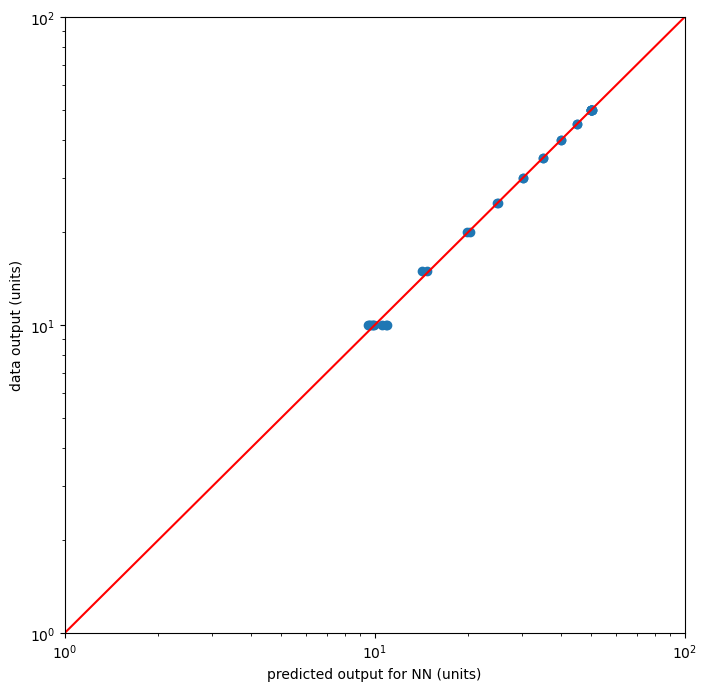

In [5]:

predictions = model.predict(data_inputs)



#SETTING UP PLOT
%matplotlib inline
# importing the required module
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [8, 8] # for square canvas 
#========

'''CALCULATE PREDICTED VALUES AND RETRIEVE DATA VALUES TO PLOT'''

plt.scatter(predictions[:, 0], data_outputs[:, 0])
#plt.title('Genetic Algorithm training of Neural Network ==> output = alpha')
plt.xlabel('predicted output for NN (units)') 
plt.ylabel('data output (units)')
plt.loglog()
plt.xlim(xmax = 100, xmin = 1.)
plt.ylim(ymax = 100, ymin = 1.)
# Generate red y=x line
x_data = np.linspace(1.0, 100.0, num=3)
y_data = x_data
plt.plot(x_data, y_data, color='red')
plt.show()


 

1/1 [==============================] - 0s 17ms/step
x=  0.0 , y=  0.0 T=  49.876724
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  0.5 T=  49.979595
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  1.0 T=  50.074192
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  1.5 T=  50.141243
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  2.0 T=  49.80535
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  2.5 T=  45.082844
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  3.0 T=  39.916042
1/1 [==============================] - 0s 7ms/step
x=  0.0 , y=  3.5 T=  35.058758
1/1 [==============================] - 0s 6ms/step
x=  0.0 , y=  4.0 T=  30.022491
1/1 [==============================] - 0s 6ms/step
x=  0.0 , y=  4.5 T=  24.850698
1/1 [==============================] - 0s 6ms/step
x=  0.0 , y=  5.0 T=  20.34346
1/1 [==============================] - 0s 7ms/step
x=  0.5 , y=  0.0 T=  49.989563
1/1 [

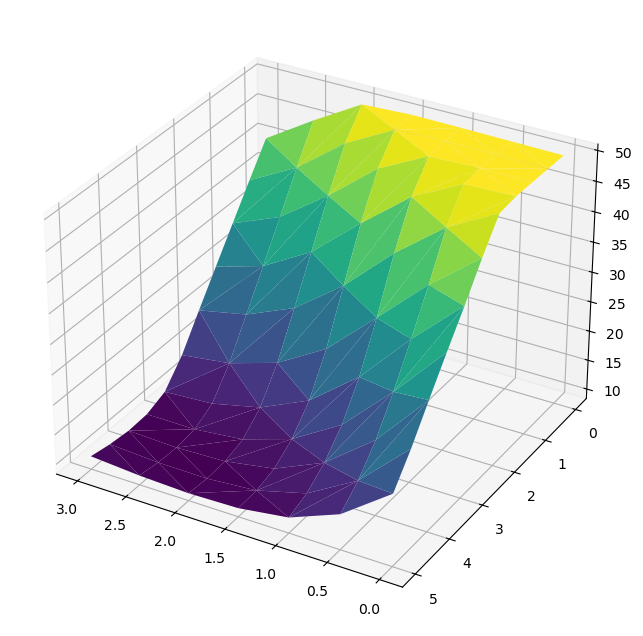

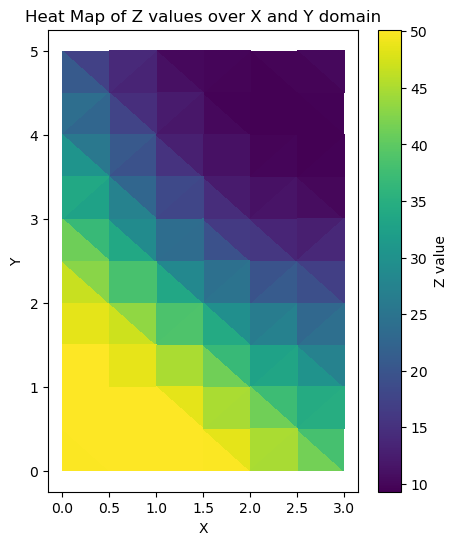

In [6]:
test = []
outpt=[]
predictions = model.predict(data_inputs)

#first point (row [0])comparison of data and prediction
# put in a loop to print comparion for all data points

xa=[]
ya=[]
za=[]

xao = np.linspace(0, 3, 7)  # 1D array for x values
yao = np.linspace(0, 5, 11)    # 1D array for y values
xa = np.linspace(0, 10, 77)    # 1D array for x values
ya = np.linspace(0, 10, 77)    # 1D array for y values
za = np.linspace(0, 10, 77)    # 1D array for z values

x =-0.50
ia=-1
while (x < 2.51):
    x = x + 0.5
    y = -0.5
    while (y < 4.51):
        ia=ia+1
        y = y + 0.50
        xa[ia]=x
        ya[ia]=y
       
        test = [[ x , y ]]
        testarray = np.array(test)
        outpt = model.predict(testarray)
        za[ia] = outpt
        print ('x= ', testarray[0][0], ', y= ', testarray[0][1],'T= ', outpt[0][0])
        


X, Y, Z = xa, ya, za

import sys
#import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Plot X,Y,Z

# Creating figure
#fig = plt.figure(figsize =(16, 9))  
#ax = plt.axes(projection ='3d') 

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection ='3d')
#ax.plot_trisurf(X, Y, Z, color='white', edgecolors='grey', alpha=0.5)
ax.plot_trisurf(X, Y, Z,
                linewidth = 0.2,
                antialiased = True
                , cmap='viridis');
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()



# Plot the data
plt.figure(figsize=(5, 6))
plt.tripcolor(xa, ya, za, shading='flat', cmap='viridis')
plt.colorbar(label='Z value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heat Map of Z values over X and Y domain')
plt.show()
